In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
from networks import AutoEncoder
from networks import ComposedAutoEncoder
from dataset import NumpyCsvDataSet

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import time
import os
from io import StringIO

In [3]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [4]:
data_folder = 'data/demoplanner/version1'
train_data = NumpyCsvDataSet(data_folder + '/train.csv')
test_data = NumpyCsvDataSet(data_folder + '/test.csv')
training_loader = DataLoader(train_data, batch_size=50, shuffle=True)
test_loader = DataLoader(test_data, batch_size=3, shuffle=True)

In [5]:
print (train_data.data.shape)
print (test_data.data.shape)

torch.Size([13280, 2058])
torch.Size([1341, 2058])


In [6]:
x_dim = 2
img_res = 32
img_size = img_res * img_res

In [37]:
%reset -f AutoEncoder
%reset -f ComposedAutoEncoder
%reset -f net
from networks import AutoEncoder

Don't know how to reset  autoencoder, please run `%reset?` for details
Don't know how to reset  composedautoencoder, please run `%reset?` for details
Don't know how to reset  net, please run `%reset?` for details


In [38]:
net = ComposedAutoEncoder()
net.train()

ComposedAutoEncoder(
  (encoder): ImageEncoder(
    (net): Sequential(
      (enc_conv0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (enc_relu0): ReLU()
      (enc_conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (enc_relu1): ReLU()
      (enc_conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (enc_relu2): ReLU()
    )
  )
  (decoder): ImageDecoder(
    (net): Sequential(
      (dec_convt0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (dec_relu0): ReLU()
      (dec_convt1): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (dec_relu1): ReLU()
      (dec_convt2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (dec_sigmoid2): Sigmoid()
      (dec_flat2): Flatten()
    )
  )
)

In [39]:
expt_prefix = 'Training-AutoEncoder-'
expt_name = expt_prefix + time.strftime('%m-%d-%H-%M-%S')
print (expt_name)

Training-AutoEncoder-03-03-11-31-51


In [40]:
# expt_name = 'Training-AutoEncoder-01-18-16-55-55'
folder = './saved_model/img_auto_encoder/' + expt_name
PATH = folder + '/autoenc.pth'

In [41]:
writer = SummaryWriter('runs/' + expt_name)

In [42]:
def model_input(data):
    return data[:, 2*x_dim:2*x_dim+img_size]

In [43]:
def writeline(builder, line):
    builder.write(line)
    builder.write('\r\n')
    
builder = StringIO()

writeline(builder, '--------------------------------------------')
writeline(builder, '        Network Parameter Statistics')
writeline(builder, '--------------------------------------------')

total = 0
layer = 0
for p in net.parameters():
    if p.requires_grad:
        total += p.numel()
        writeline(builder, 'Params for layer {} = {}'.format(layer+1, p.numel()))
        layer += 1

writeline(builder, '--------------------------------------------')
writeline(builder, 'Total: {}'.format(total))
writeline(builder, '--------------------------------------------')

paramString = builder.getvalue()
print (paramString)

# writer.add_text('Network Parameter Info', paramString)

# print (net)

data = next(iter(training_loader)).float()

# writer.add_graph(net, model_input(data))

lines = str(net).split('\n')
builder2 = StringIO()
# print ('Number of lines = {}'.format(len(lines)))
for i, l in enumerate(lines):
    if l.strip() == "":
        continue
    print(l)
    writeline(builder2, l)
    # writer.add_text('Network Structure', l, i)

builder.close()
builder2.close()

--------------------------------------------
        Network Parameter Statistics
--------------------------------------------
Params for layer 1 = 36
Params for layer 2 = 4
Params for layer 3 = 288
Params for layer 4 = 8
Params for layer 5 = 1152
Params for layer 6 = 16
Params for layer 7 = 1152
Params for layer 8 = 8
Params for layer 9 = 288
Params for layer 10 = 4
Params for layer 11 = 36
Params for layer 12 = 1
--------------------------------------------
Total: 2993
--------------------------------------------

ComposedAutoEncoder(
  (encoder): ImageEncoder(
    (net): Sequential(
      (enc_conv0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (enc_relu0): ReLU()
      (enc_conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (enc_relu1): ReLU()
      (enc_conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (enc_relu2): ReLU()
    )
  )
  (decoder): ImageDecoder(
    (net): Sequential(
      (dec_convt0):

In [46]:
## Training auto encoder and dynamics network
resume_previous_training = True
epochs = 100
if not resume_previous_training:
    prev_offset = 0

optimizer = optim.Adam(net.parameters(), lr=1e-4)

running_loss = np.array([0.0, 0.0, 0.0, 0.0])
for epoch in range(epochs):
    for i, data in enumerate(training_loader, 0):
        data = data.float()
        ip_batch = model_input(data)
        # Divide by 255 to scale the input to bring between 0 and 1
        ip_batch = ip_batch / 255
        op_batch = net(ip_batch)
        total_loss = F.mse_loss(op_batch, ip_batch)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        if i % 100 == 99:
            avg_loss = running_loss / 100
            print ('[%d, %5d] loss: %.3f' % (prev_offset+epoch+1, i+1, avg_loss[0]))
            index = (prev_offset+epoch) * len(training_loader) + i
            writer.add_scalar('training_loss', avg_loss[0], index)
            running_loss[:] = 0.0

prev_offset += epochs

[201,   100] loss: 0.019
[201,   200] loss: 0.018
[202,   100] loss: 0.028
[202,   200] loss: 0.015
[203,   100] loss: 0.024
[203,   200] loss: 0.013
[204,   100] loss: 0.020
[204,   200] loss: 0.011
[205,   100] loss: 0.016
[205,   200] loss: 0.009
[206,   100] loss: 0.013
[206,   200] loss: 0.007
[207,   100] loss: 0.012
[207,   200] loss: 0.007
[208,   100] loss: 0.011
[208,   200] loss: 0.006
[209,   100] loss: 0.010
[209,   200] loss: 0.006
[210,   100] loss: 0.010
[210,   200] loss: 0.006
[211,   100] loss: 0.009
[211,   200] loss: 0.006
[212,   100] loss: 0.009
[212,   200] loss: 0.005
[213,   100] loss: 0.009
[213,   200] loss: 0.005
[214,   100] loss: 0.009
[214,   200] loss: 0.005
[215,   100] loss: 0.008
[215,   200] loss: 0.005
[216,   100] loss: 0.008
[216,   200] loss: 0.005
[217,   100] loss: 0.008
[217,   200] loss: 0.005
[218,   100] loss: 0.008
[218,   200] loss: 0.005
[219,   100] loss: 0.008
[219,   200] loss: 0.005
[220,   100] loss: 0.008
[220,   200] loss: 0.005


MSE: 0.00205573090352118


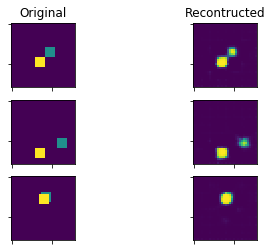

In [47]:
with torch.no_grad():
    test_data = iter(test_loader).next()
#     test_img = np.random.randint(len(test_data))
#     data = torch.as_tensor(test_data[test_img].reshape(1,-1))
    test_data = test_data.float()
    ip = model_input(test_data)
    ip_n = ip / 255 
    op_n = net(ip_n)
    op = torch.floor(op_n * 255) # Post processing to match the pre-processing of inputs in network
    rows = 3 # test_batch size
    
    print ('MSE: {}'.format(np.mean(np.abs(ip_n.numpy() - op_n.numpy()) ** 2)))
    
    fig = plt.figure()
    
    for r in range(rows):
        ax = plt.subplot(rows,2,r*2 + 1)
        orig_image = ip[r].reshape(img_res, img_res)
        plt.imshow(orig_image)
        # writer.add_image(str.format('test_original_{}', r), orig_image)
        if r==0:
            ax.title.set_text('Original')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax = plt.subplot(rows,2,r*2 + 2)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        recon_image = op[r].reshape(img_res, img_res)
        plt.imshow(recon_image)
        # writer.add_image(str.format('test_recontructed_{}', r), recon_image)
        if r==0:
            ax.title.set_text('Recontructed')
    plt.show()
    writer.add_figure('test_image_matplotlib', fig)


In [32]:
print (ip[0].numpy())
print (np.array(op[0].numpy(), dtype=int))

[0. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 1]


In [33]:
np.set_printoptions(**opt)

In [34]:
os.makedirs(folder)
torch.save(net.state_dict(), PATH)

In [35]:
test_net = AutoEncoder()
test_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>